## Data

- https://www.governing.com/gov-data/safety-justice/law-enforcement-police-department-employee-totals-for-cities.html
- https://www.census.gov/data/tables/time-series/demo/popest/2010s-total-cities-and-towns.html#ds
- https://simplemaps.com/data/us-cities
- https://killedbypolice.net/
- https://docs.google.com/spreadsheets/d/1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE/edit#gid=0
- https://mappingpoliceviolence.org/aboutthedata
- https://www.taxpolicycenter.org/statistics/state-and-local-general-expenditures-capita
- https://public.opendatasoft.com/explore/dataset/us-cities-demographics/table/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6InVzLWNpdGllcy1kZW1vZ3JhcGhpY3MiLCJvcHRpb25zIjp7fX0sImNoYXJ0cyI6W3siYWxpZ25Nb250aCI6dHJ1ZSwidHlwZSI6ImNvbHVtbiIsImZ1bmMiOiJBVkciLCJ5QXhpcyI6Im1lZGlhbl9hZ2UiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiIjRkY1MTVBIn1dLCJ4QXhpcyI6ImNpdHkiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIn1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

### Clean data for Bubble Map

In [297]:
# clean fatal encounters from missing values
pop = pd.read_csv('../uscities.csv') #, encoding = "ISO-8859-1"
us_pop = pd.read_csv('../POPTOTUSA647NWDB.csv')
pop_race = pd.read_csv('data/us-cities-demographics.csv', sep=";")
state_abr = pd.read_csv('../abbr-name-list.csv')
police_officers = pd.read_csv('../police_officers.csv')
votes = pd.read_csv('../countypres_2000-2016.csv')
spending = pd.read_csv('../results.csv', skiprows=[0,1])
df = pd.read_csv("../fatal_encounters.csv")
df.shape

(28837, 29)

In [298]:
df = df.dropna(subset=['Longitude', 'Latitude'])
df.shape

(28836, 29)

In [7]:
df.to_csv('data/fatal_encounters_cl.csv')

In [4]:
# get counties centroids
counties = gpd.read_file("../geodata/tl_2017_us_county.shp")

In [209]:
# counties['NAME'] = counties['name']

In [163]:
# counties['centroid'] = counties['geometry'].centroid

In [61]:
# aggregated since 2000
df['death_count'] = 1 
# df = df[["Subject's name", "Subject's age", "Subject's race", "Subject's gender", 
#          "Date of injury resulting in death (month/day/year)", 
#          "Location of death (county)", "Latitude", "Longitude",
#          "Date (Year)", "death_count"]]
df[["Latitude", "Longitude","death_count"]] = df[["Latitude", "Longitude","death_count"]].apply(pd.to_numeric)



df = df.groupby("Location of death (county)").agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
df.columns = ["county", "Latitude", "Longitude","death_count"]

df = df.dropna(subset=['Longitude', 'Latitude'])

df.to_csv("data/countiesDeaths.csv")

In [77]:
# by month/year
df['death_count'] = 1 
# df = df[["Subject's name", "Subject's age", "Subject's race", "Subject's gender", 
#          "Date of injury resulting in death (month/day/year)", 
#          "Location of death (county)", "Latitude", "Longitude",
#          "Date (Year)", "death_count"]]

df['month'] = df['Date of injury resulting in death (month/day/year)'].str[:2]

df['month_year'] = df['month'].astype('str') + "/" + df['Date (Year)'].astype('str')

df[["Latitude", "Longitude","death_count"]] = df[["Latitude", "Longitude","death_count"]].apply(pd.to_numeric)



df = df.groupby(["Location of death (county)", "month_year"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
df.columns = ["county", "date", "Latitude", "Longitude","death_count"]

df = df.dropna(subset=['Longitude', 'Latitude'])

df.to_csv("data/citiesYearDeaths.csv")

In [5]:
# by year
df['death_count'] = 1 
# df = df[["Subject's name", "Subject's age", "Subject's race", "Subject's gender", 
#          "Date of injury resulting in death (month/day/year)", 
#          "Location of death (county)", "Latitude", "Longitude",
#          "Date (Year)", "death_count"]]

df[["Latitude", "Longitude","death_count"]] = df[["Latitude", "Longitude","death_count"]].apply(pd.to_numeric)



df = df.groupby(["Location of death (city)", "Date (Year)"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
df.columns = ["county", "date", "Latitude", "Longitude","death_count"]


In [7]:
# add population for that city


In [ ]:
df = df.dropna(subset=['Longitude', 'Latitude'])

df.to_csv("data/citiesYearDeaths.csv")

### Clean data for line chart

In [4]:
import requests
import pandas as pd
from zipfile import ZipFile

#scrape police officers by city
# police_officers = pd.read_html('https://www.governing.com/gov-data/safety-justice/law-enforcement-police-department-employee-totals-for-cities.html')[0]
police_officers = pd.read_html('https://www.governing.com/gov-data/safety-justice/police-officers-per-capita-rates-employment-for-city-departments.html')
police_officers[2].to_csv('police_officers.csv')
police_officers = police_officers[2]

In [192]:
# population by race for US cities
# change race names to match fatal encounters
pop_race["Location of death (city)"] =  pop_race["City"] + ", " + pop_race["State Code"]
pop_race['Race'][pop_race['Race']=='Black or African-American'] = 'African-American/Black'
pop_race['Race'][pop_race['Race']=='White'] = 'European-American/White'
pop_race['Race'][pop_race['Race']=='Hispanic or Latino'] = 'Hispanic/Latino'

# subset race data for black white hispanic only and population only
pop_race = pop_race[pop_race['Race'].isin(['African-American/Black', 'European-American/White', 'Hispanic/Latino'])]

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [193]:
pop_race = pop_race[['Location of death (city)', 'Count', 'Total Population', "Race"]]
pop_race

,Location of death (city),Count,Total Population,Race
0,"Framingham, MA",6944,71210,African-American/Black
4,"Maple Grove, MN",59683,68381,European-American/White
6,"Torrance, CA",5906,148468,African-American/Black
8,"San Diego, CA",949388,1394907,European-American/White
12,"Maple Grove, MN",1685,68381,Hispanic/Latino
...,...,...,...,...
2885,"Birmingham, AL",8940,214911,Hispanic/Latino
2886,"Boca Raton, FL",14735,93226,Hispanic/Latino
2887,"Fort Lauderdale, FL",28148,178587,Hispanic/Latino
2888,"Oxnard, CA",165423,207252,European-American/White


In [129]:
df_race

,Date (Year),Subject's race,Location of death (city),Latitude,Longitude,death_count,population
0,2000,African-American/Black,"Atlanta, GA",33.758454,-84.389228,2,5228750.0
1,2000,African-American/Black,"Aurora, CO",39.725516,-104.823497,1,366623.0
2,2000,African-American/Black,"Austin, TX",30.274613,-97.721093,1,1638716.0
3,2000,African-American/Black,"Baton Rouge, LA",30.423967,-91.139497,1,583613.0
4,2000,African-American/Black,"Battle Creek, MI",42.333512,-85.203441,1,76803.0
...,...,...,...,...,...,...,...
19357,2020,Hispanic/Latino,"Topeka, KS",39.043730,-95.669304,2,148960.0
19358,2020,Hispanic/Latino,"Tracy, CA",37.763195,-121.437911,2,95982.0
19359,2020,Hispanic/Latino,"Tucson, AZ",32.213351,-110.944134,6,868391.0
19360,2020,Hispanic/Latino,"Vallejo, CA",38.122572,-122.251639,1,173844.0


In [195]:
test = pd.merge(df_race, pop_race,  how='inner', left_on=["Subject's race",'Location of death (city)'], right_on = ['Race','Location of death (city)'])

test = test.drop("population", axis = 1)
# test[test['Location of death (city)']=="Atlanta, GA"]
test = test.groupby(["Date (Year)", "Subject's race"]).agg(
    {"Latitude": "mean", "Longitude": "mean", "death_count": "sum", "Total Population": "mean", "Count": "sum"}).reset_index()

test['death_hthou'] = test['death_count']/test['Count']*100000

In [10]:
df = pd.read_csv('data/fatal_encounters_cl.csv')

In [13]:
# spending on police by state
spending = spending.replace({"DC":"District Of Columbia"})[~spending.State.str.contains("Data may be unavailable for some years")]
spending = pd.merge(state_abr.append({'name': 'United States', 'abbreviation': 'United States'}, ignore_index=True), spending, 
                    left_on='name', right_on='State', how='right')

spending['police_exp'] = pd.to_numeric(spending['(E019) Police & Fire Protection-Dir Exp'].str[1:]) + pd.to_numeric(spending['(E087) Police Prot-Direct Exp'].str[1:]) + pd.to_numeric(spending['(E088) Police Prot-Cur Oper (E62)'].str[1:]) + pd.to_numeric(spending['(E089) Police Prot-Cap Outlay'].str[1:])
spending = spending[['abbreviation', 'Year', 'police_exp']]
# spending = spending.drop(columns=["name", "State"])
# spending['State'][spending['State']!= 'United States'] = spending['State'] + ", " + spending['abbreviation']

In [299]:
# compute majority party by city
votes = votes[votes['year'] == 2016]
votes['county'] = votes['county'] + ", " + votes['state_po']
votes = votes[['county', 'party', 'candidatevotes']].dropna()

votes = votes.pivot_table(index = 'county', columns='party', values='candidatevotes').reset_index()
votes['party'] = "r"
votes['party'][votes['democrat']>votes['republican']] = 'blue'
votes['party'][votes['democrat']<votes['republican']] = 'red'
votes = votes[['county', 'party']].dropna()

city_key = pop[['city', 'county_name', 'state_id']]
city_key['city'], city_key['county_name'] = city_key["city"] + ", " + city_key["state_id"], city_key["county_name"] + ", " + city_key["state_id"]
votes = pd.merge(votes, city_key, left_on='county', right_on='county_name', how='left')
votes = votes[['city', 'party']].dropna()

# police officers by city
police_officers = pd.merge(police_officers, state_abr, left_on='State', right_on='name')
police_officers['city'] = police_officers['City'] + ", " + police_officers['abbreviation']
police_officers = police_officers[['city', 'Total Officers']]

df = df[["Subject's name", "Subject's age", "Subject's race", "Subject's gender", 
         "Date of injury resulting in death (month/day/year)", 
         "Latitude", "Longitude", "Date (Year)", "Location of death (city)", "Location of death (state)"]]

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de

In [66]:
# # group by everything, month
# df['death_count'] = 1 

# df['month'] = df['Date of injury resulting in death (month/day/year)'].str[:2]

# df['month_year'] = df['month'].astype('str') + "/" + df['Date (Year)'].astype('str')

# df = df.groupby("month_year").agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "Date (Year)": "mean"}).reset_index()

In [21]:
# # group by race, month
# df['death_count'] = 1 

# df['month'] = df['Date of injury resulting in death (month/day/year)'].str[:2]

# df['month_year'] = df['month'].astype('str') + "/" + df['Date (Year)'].astype('str')

# df['Location of death (city)'] = df['Location of death (city)'].astype('str') + " city"

# df_month = df.groupby(["month_year", "Subject's race"]).agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "Date (Year)": "mean"}).reset_index()

# df = df.groupby(["Date (Year)", "Subject's race"]).agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()

In [201]:
pop_race

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Framingham,Massachusetts,40.3,35442.0,35768.0,71210,2625.0,19070.0,2.49,MA,Black or African-American,6944
1,Waco,Texas,29.3,63452.0,68890.0,132342,10716.0,14235.0,2.57,TX,Asian,4230
2,Fort Worth,Texas,32.6,414126.0,422843.0,836969,39182.0,143404.0,2.88,TX,American Indian and Alaska Native,7504
3,Bellingham,Washington,30.7,41286.0,43857.0,85143,4703.0,8713.0,2.44,WA,American Indian and Alaska Native,2056
4,Maple Grove,Minnesota,38.6,31780.0,36601.0,68381,2943.0,7645.0,2.64,MN,White,59683
...,...,...,...,...,...,...,...,...,...,...,...,...
2886,Boca Raton,Florida,47.3,44760.0,48466.0,93226,4367.0,21117.0,2.22,FL,Hispanic or Latino,14735
2887,Fort Lauderdale,Florida,42.8,93948.0,84639.0,178587,8897.0,47582.0,2.38,FL,Hispanic or Latino,28148
2888,Oxnard,California,31.0,101906.0,105346.0,207252,6367.0,78678.0,4.08,CA,White,165423
2889,Somerville,Massachusetts,31.0,41028.0,39306.0,80334,2103.0,22292.0,2.43,MA,White,62927


In [300]:
# group by race, month, county

pop['city'] = pop['city'] + ", " + pop['state_id']
pop = pop[['city', 'population']]

# pop_race['City'] = pop_race['City'] + ", " + pop_race['State Code']
# pop = pop_race[['City', 'Total Population']]
# pop.columns = ['city', 'population']
# pop = pop.groupby('city').mean().reset_index()

df["Location of death (city)"] = df["Location of death (city)"] + ", " + df["Location of death (state)"]

df = pd.merge(df, pop, left_on='Location of death (city)', right_on='city')

police_officers = pd.merge(police_officers, pop, left_on='city', right_on='city')

# df = df[df['population']!=0][df['population']>100000]

df['death_count'] = 1 

df['month'] = df['Date of injury resulting in death (month/day/year)'].str[:2]

df['month_year'] = df['month'].astype('str') + "/" + df['Date (Year)'].astype('str')

df_month = df.groupby(["month_year", "Subject's race", "Location of death (city)"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "Date (Year)": "mean"}).reset_index()

# Aggregated Line chart by race
# df_race = df.groupby(["Date (Year)", "Subject's race", "Location of death (city)"]).agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "population": "mean"}).reset_index()

# df_race = df_race[df_race["Subject's race"].isin(['African-American/Black', 'Hispanic/Latino', 'European-American/White'])]

df = df.groupby(["Date (Year)", "Location of death (city)"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "population": "mean"}).reset_index()

# compute total for United States
us_tot = df.groupby("Date (Year)").agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
us_tot['population'] = np.append(np.array(us_pop[us_pop['DATE']>'1999-01-01']['POPTOTUSA647NWDB']), 0)
us_tot['Location of death (city)'] = 'United States'

# # compute total for United States by race
# us_tot_race = df_race.groupby(["Date (Year)", "Subject's race"]).agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
# us_tot_race['population'] = np.append(np.array(us_pop[us_pop['DATE']>'1999-01-01']['POPTOTUSA647NWDB']), 0)
# us_tot_race['Location of death (city)'] = 'United States'

# police officers
# df = pd.merge(df, police_officers, left_on='Location of death (city)', right_on='city')
# df['population'] = df['population_x']
# df = df.drop(columns=['population_x', 'population_y', 'city'])

df = df.append(us_tot)
# df_race = df_race.append(us_tot_race)

df['death_hthou'] = df['death_count']/df['population']*100000
# df_race['death_hthou'] = df_race['death_count']/df_race['population']*1000000
police_officers['police_hthou'] = police_officers['Total Officers']/police_officers['population']*100000

In [218]:
# df_race.groupby("Date (Year)", "Subject's race").agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()

### normalized map


In [231]:
# add party
df = pd.merge(df, votes, left_on='Location of death (city)', right_on='city', how='inner')#.drop('county', axis=1)

In [232]:
# by year
df[["Latitude", "Longitude","death_count", "death_hthou"]] = df[["Latitude", "Longitude","death_count", "death_hthou"]].apply(pd.to_numeric)


df = df.groupby(["Location of death (city)", "Date (Year)", "party"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "death_hthou": "mean", "population":"mean"}).reset_index()

df.columns = ["county", "date", "party", "Latitude", "Longitude","death_count", "death_hthou", "population"]

In [234]:
df[df['county']!="United States"].to_csv("data/citiesYearDeathsHT_party_n.csv")

### Small Multiples

In [434]:
# for small multiples
df = df[df['Date (Year)'].isin([2000, 2010, 2019])].drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
         values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
                                                                    'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

# df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
#          values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
#                                                                     'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

df['change'] = df[2019] - df[2000]
df['%_change'] = ((df[2019] - df[2000])/df[2000])*100


## Sort by % change
df_most = df.sort_values('%_change', ascending=False).head(20).append(df[df['county']=='United States'])
df_least = df.sort_values('%_change', ascending=True).head(20).append(df[df['county']=='United States'])

# Sort by number of Officers

df_most = pd.melt(df_most, id_vars = ['county', '%_change'], value_vars=[2000, 2010, 2019]).rename(columns = {'county': 'city', 
                                                                    'Date (Year)': 'year'})

df_least = pd.melt(df_least, id_vars = ['county', '%_change'], value_vars=[2000, 2010, 2019]).rename(columns = {'county': 'city', 
                                                                    'Date (Year)': 'year'})



df_most.to_csv('deaths_by_city_sm_most.csv')
df_least.to_csv('deaths_by_city_sm_least.csv')

### Pick Up Here!

### Police officers by City

In [301]:
years = [2000, 2010, 2019] #[2000, 2010, 2019] #np.arange(2000, 2020)
chart_wanted = "SC" # SM for small multiples and SC for scatter

# for scatter plot and small multiples by police officers
df = df[df['Date (Year)'].isin(years)].drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
         values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
                                                                    'Location of death (city)': 'county'}).dropna(subset=[2000])

# df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
#          values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
#                                                                     'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

df['change'] = df[years[-1]] - df[years[0]]
df['%_change'] = ((df[years[-1]] - df[years[0]])/df[years[0]])*100

if chart_wanted == "SC":
    df = pd.merge(df, police_officers, left_on='county', right_on='city').drop('city', axis=1).append(df[df['county']=='United States'])

    df = df[df['county']!='Newark, NJ']

## Sort by % change
    df_most = df.sort_values('police_hthou', ascending=False).head(20).append(df[df['county']=='United States'])
    df_least = df.sort_values('police_hthou', ascending=True).head(20).append(df[df['county']=='United States'])

    df_most = pd.melt(df_most, id_vars = ['county', '%_change'], value_vars=years).rename(columns = {'county': 'city', 
                                                                        'variable': 'year'})

    df_least = pd.melt(df_least, id_vars = ['county', '%_change'], value_vars=years).rename(columns = {'county': 'city', 
                                                                        'variable': 'year'})

# df.columns = df.columns.astype('str')

# party
df_votes = pd.merge(df, votes, left_on='county', right_on='city', how='inner')#.drop('county', axis=1)

if chart_wanted == "SM":
    df_party = pd.merge(df_votes, pop, on='city')
    df_red = df_party[df_party['party']=='red'].sort_values('population', ascending=False).dropna(subset=[2000,2019]).head(20)
    df_blue = df_party[df_party['party']=='blue'].sort_values('population', ascending=False).dropna(subset=[2000,2019]).head(20)
    df_party = df_red.append(df_blue).sort_values('population', ascending=False).drop('population', axis = 1)
    
    # sort by party
    df = df.rename(columns={"county": "city"})
    df_party = pd.melt(df_party.append(df[df['city']=='United States']), id_vars = ['city', '%_change', 'party'], 
                                       value_vars=years).rename(columns = {'city': 'city','variable': 'year'})


df_votes = df_votes.drop('county', axis=1)
df_votes.columns = ['d_2000', 'd_2010', 'd_2019', 'change', '%_change', 'Total Officers', 'population', 'police_hthou', 'city', 'party']

# df_votes.to_csv('deaths_vs_officers.csv')
# df_most.to_csv('deaths_by_city_sm_mostp_ty.csv')
# df_least.to_csv('deaths_by_city_sm_leastp_line_ty.csv')
# df_party.to_csv('death_by_city_party.csv')

In [303]:
df_votes.to_csv('data/deaths_vs_officers.csv')

In [286]:
df_party.to_csv('data/death_by_city_party.csv')

In [9]:
# df_party = pd.merge(df_votes, pop, on='city')
# df_red = df_party[df_party['party']=='red'].sort_values('population', ascending=False).dropna().head(10)
# df_blue = df_party[df_party['party']=='blue'].sort_values('population', ascending=False).dropna().head(10)
# df_party = df_red.append(df_blue).sort_values('population', ascending=False).drop('population', axis = 1)


### Aggregated party over time

In [18]:
import seaborn as sns
df_party_agg = df_party.groupby(['year', 'party']).mean().reset_index()
sns.lineplot(data = df_party, x = 'year', y='value', hue='party')

In [24]:
# df_party_agg = df_party_agg.pivot(index = 'year', columns='party', 
#          values='value').reset_index()

df_party_agg.to_csv('death_by_city_party_agg.csv')

In [25]:
df_party_agg

party,year,blue,red
0,2000,1.940851,4.378451
1,2001,1.931301,5.713283
2,2002,2.141052,3.257630
3,2003,2.204077,4.517799
4,2004,2.070590,6.953844
5,2005,2.346532,4.279265
6,2006,2.591513,4.354105
7,2007,2.724241,4.204137
8,2008,2.499382,5.272696
9,2009,2.412901,3.833319


### Per Capita Police Spending by City

In [422]:
df['state'] = df['city'].str.split(', ').str[1]

df = pd.merge(df, spending[spending['Year']=='2017'], left_on='state', right_on='abbreviation').drop(['Year', 'abbreviation'], axis=1)

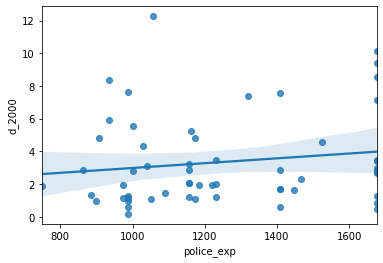

In [434]:
import seaborn as sns
sns.regplot(data = df, x='police_exp', y='d_2000')

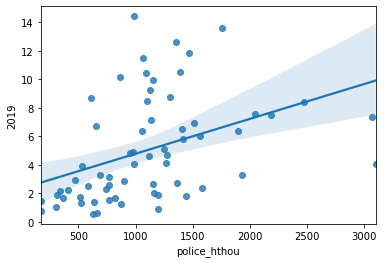

In [60]:
import seaborn as sns
sns.regplot(data = df[df['county']!='Newark, NJ'], x='police_hthou', y=df[2019])

In [315]:
# for small multiples all data points
# df = df[df['Date (Year)'].isin([2000, 2010, 2019])].drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
#          values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
#                                                                     'Location of death (city)': 'county'}).dropna()

df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
         values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
                                                                    'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

df['change'] = df[2019] - df[2000]
df['%_change'] = ((df[2019] - df[2000])/df[2000])*100

df_most = df.sort_values('%_change', ascending=False).head(20).append(df[df['county']=='United States'])
df_least = df.sort_values('%_change', ascending=True).head(20).append(df[df['county']=='United States'])

# df_most = pd.melt(df_most, id_vars = ['county', '%_change'], value_vars=list(np.arange(2000, 2020))).rename(columns = {'county': 'city', 
#                                                                     'Date (Year)': 'year'})

# df_least = pd.melt(df_least, id_vars = ['county', '%_change'], value_vars=list(np.arange(2000, 2020))).rename(columns = {'county': 'city', 
#                                                                     'Date (Year)': 'year'})

# df_most.to_csv('deaths_by_city_sm_most.csv')
# df_least.to_csv('deaths_by_city_sm_least.csv')

In [8]:
# for scatter plot and small multiples by police officers all data points
df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
         values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
                                                                    'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

# df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
#          values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
#                                                                     'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

df['change'] = df[2019] - df[2000]
df['%_change'] = ((df[2019] - df[2000])/df[2000])*100

df = pd.merge(df, police_officers, left_on='county', right_on='city').drop('city', axis=1).append(df[df['county']=='United States'])

df = df[df['county']!='Newark, NJ']
df = df[df['county']!='Bakersfield, CA']

## Sort by % change
df_most = df.sort_values('police_hthou', ascending=False).head(20).append(df[df['county']=='United States'])
df_least = df.sort_values('police_hthou', ascending=True).head(20).append(df[df['county']=='United States'])

# Sort by number of Officers

df_most = pd.melt(df_most, id_vars = ['county', '%_change'], value_vars=list(np.arange(2000, 2020))).rename(columns = {'county': 'city', 
                                                                    'variable': 'year'})

df_least = pd.melt(df_least, id_vars = ['county', '%_change'], value_vars=list(np.arange(2000, 2020))).rename(columns = {'county': 'city', 
                                                                    'variable': 'year'})

df.columns = ['']

df.to_csv('deaths_vs_officers.csv')
# df_most.to_csv('deaths_by_city_sm_mostp_all.csv')
# df_least.to_csv('deaths_by_city_sm_leastp_all.csv')

In [22]:
df["Subject's race"].unique()
df = df[df["Subject's race"].isin(['African-American/Black', 'Hispanic/Latino', 'European-American/White'])]

df_month["Subject's race"].unique()
df_month = df_month[df_month["Subject's race"].isin(['African-American/Black', 'Hispanic/Latino', 'European-American/White'])]

In [23]:
# df['race_pop'][df["Subject's race"]=="African-American/Black"][df["Date (Year)"]==2000]
# df['race_pop'][df["Subject's race"]=="African-American/Black"][df["Date (Year)"]==2000]
# df['race_pop'][df["Subject's race"]=="African-American/Black"][df["Date (Year)"]==2000]

In [25]:
import seaborn as sns
# df['month_year'] = pd.to_datetime(df['month_year']) 
df['race_pop'] = 0

df['race_pop'][df["Subject's race"]=="African-American/Black"] = 44080000
df['race_pop'][df["Subject's race"]=='European-American/White'] = 250520000
df['race_pop'][df["Subject's race"]=='Hispanic/Latino'] = 52000000

df_month['race_pop'] = 0

df_month['race_pop'][df_month["Subject's race"]=="African-American/Black"] = 44080000
df_month['race_pop'][df_month["Subject's race"]=='European-American/White'] = 250520000
df_month['race_pop'][df_month["Subject's race"]=='Hispanic/Latino'] = 52000000

In [30]:
df['deaths_hThousands'] = df['death_count']/df['race_pop']*1000000
df = df[df["Date (Year)"]<2020]
df['pop_prop'] = df['race_pop']/328200000
df.columns = ["date", "race", 'Latitude', 'Longitude', 'death_count', 'race_pop', 'deaths_thousands', 'pop_prop']
df = df[["date", "race", 'death_count', 'race_pop', 'deaths_thousands', 'pop_prop']]

df_month['deaths_hThousands'] = df_month['death_count']/df_month['race_pop']*1000000
df_month = df_month[df_month["Date (Year)"]<2020]
df_month['pop_prop'] = df_month['race_pop']/328200000
df_month = df_month.drop('Date (Year)', axis=1)
df_month.columns = ["date", "race", 'Latitude', 'Longitude', 'death_count', 'race_pop', 'deaths_thousands', 'pop_prop']
df_month = df_month[["date", "race", 'death_count', 'race_pop', 'deaths_thousands', 'pop_prop']]

In [31]:
df_month

,date,race,death_count,race_pop,deaths_thousands,pop_prop
0,01/2000,African-American/Black,13,44080000,0.294918,0.134308
2,01/2000,European-American/White,16,250520000,0.063867,0.763315
3,01/2000,Hispanic/Latino,5,52000000,0.096154,0.158440
6,01/2001,African-American/Black,8,44080000,0.181488,0.134308
8,01/2001,European-American/White,6,250520000,0.023950,0.763315
...,...,...,...,...,...,...
1364,12/2018,European-American/White,51,250520000,0.203577,0.763315
1365,12/2018,Hispanic/Latino,24,52000000,0.461538,0.158440
1368,12/2019,African-American/Black,42,44080000,0.952813,0.134308
1370,12/2019,European-American/White,67,250520000,0.267444,0.763315


In [165]:
test

,Date (Year),Subject's race,Latitude,Longitude,death_count,Total Population,Count,death_hthou
0,2000,African-American/Black,36.089207,-95.725438,75,556874.500000,7274893,10.309430
1,2000,European-American/White,36.842549,-102.338321,48,567799.897436,13908545,3.451116
2,2000,Hispanic/Latino,35.725296,-108.772303,35,731542.826087,6406818,5.462930
3,2001,African-American/Black,36.632090,-98.076589,59,552944.702703,4596612,12.835541
4,2001,European-American/White,38.801837,-105.049861,55,489274.761905,12723955,4.322555
...,...,...,...,...,...,...,...,...
58,2019,European-American/White,37.497761,-100.142884,222,336664.942857,31202172,7.114889
59,2019,Hispanic/Latino,35.362824,-104.216124,142,365928.348837,12588267,11.280345
60,2020,African-American/Black,36.255124,-92.519017,152,377526.112360,9759989,15.573788
61,2020,European-American/White,37.277020,-99.184543,132,289796.466019,20558108,6.420824


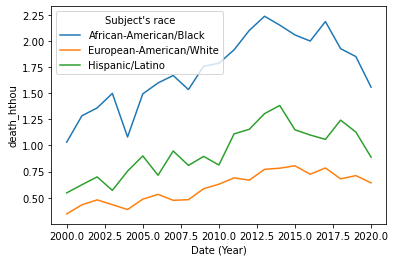

In [168]:
import seaborn as sns
sns.lineplot(data = test, x = "Date (Year)", y = 'death_hthou', hue="Subject's race")

In [18]:
df.head(5)

,date,race,death_count,race_pop,deaths_thousands,pop_prop
0,2000,African-American/Black,122,44080000,2.767695,0.134308
2,2000,European-American/White,120,250520000,0.479004,0.763315
3,2000,Hispanic/Latino,54,52000000,1.038462,0.158440
6,2001,African-American/Black,92,44080000,2.087114,0.134308
8,2001,European-American/White,118,250520000,0.471020,0.763315


In [39]:
df_month['date'] = pd.to_datetime(df_month['date']) 

,date,race,death_count,race_pop,deaths_thousands,pop_prop
0,2000-01-01,African-American/Black,13,44080000,0.294918,0.134308
2,2000-01-01,European-American/White,16,250520000,0.063867,0.763315
3,2000-01-01,Hispanic/Latino,5,52000000,0.096154,0.158440
6,2001-01-01,African-American/Black,8,44080000,0.181488,0.134308
8,2001-01-01,European-American/White,6,250520000,0.023950,0.763315
...,...,...,...,...,...,...
1364,2018-12-01,European-American/White,51,250520000,0.203577,0.763315
1365,2018-12-01,Hispanic/Latino,24,52000000,0.461538,0.158440
1368,2019-12-01,African-American/Black,42,44080000,0.952813,0.134308
1370,2019-12-01,European-American/White,67,250520000,0.267444,0.763315


In [41]:
# df_month.pivot(index='date', columns='race', 
#          values='deaths_thousands').reset_index().rename(columns = {'African-American/Black': 'black', 
#                                                                     'European-American/White': 'white', 
#                                                                     'Hispanic/Latino': 'latino'})

In [42]:
# df.pivot(index='date', columns='race', 
#          values='deaths_thousands').reset_index().rename(columns = {'African-American/Black': 'black', 
#                                                                     'European-American/White': 'white', 
#                                                                     'Hispanic/Latino': 'latino'}).to_csv("deaths_by_race.csv")
df_month.pivot(index='date', columns='race', 
         values='deaths_thousands').reset_index().rename(columns = {'African-American/Black': 'black', 
                                                                    'European-American/White': 'white', 
                                                                    'Hispanic/Latino': 'latino'}).to_csv("deaths_by_race_month.csv")

# df.groupby('date').mean().reset_index().to_csv('deaths_time.csv')

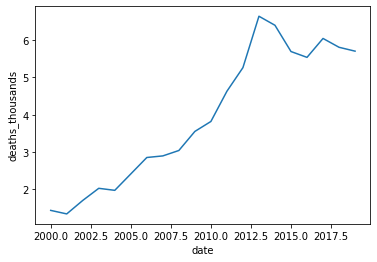

In [38]:
sns.lineplot(data = df.groupby('date').mean().reset_index(), x = "date", y = 'deaths_thousands')

In [223]:
counties_deaths = pd.merge(counties, df, left_on="NAME", 
                           right_on = "Location of death (county)", 
                           how = "left")

counties_deaths = counties_deaths[['NAME','geometry', 'death_count']]

In [225]:
counties_deaths['death_count'] = counties_deaths['death_count'].fillna(0)

In [111]:
# counties_deaths.geometry = counties_deaths.centroid

In [226]:
counties_deaths['Longitude'] = counties_deaths.geometry.centroid.x
counties_deaths['Latitude'] = counties_deaths.geometry.centroid.y

In [227]:
counties_deaths

,NAME,geometry,death_count,Longitude,Latitude
0,Cuming,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",0.0,-96.787400,41.916403
1,Wahkiakum,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",0.0,-123.433470,46.291134
2,De Baca,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",1.0,-104.411958,34.342414
3,Lancaster,"POLYGON ((-96.91060 40.95841, -96.91060 40.958...",48.0,-96.687756,40.784174
4,Nuckolls,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",0.0,-98.047185,40.176380
...,...,...,...,...,...
3228,Gilmer,"POLYGON ((-84.65478 34.66559, -84.65488 34.669...",0.0,-84.455627,34.691178
3229,Roseau,"POLYGON ((-96.40466 48.80528, -96.40467 48.813...",0.0,-95.810817,48.775139
3230,Madison,"POLYGON ((-90.09363 32.70763, -90.09360 32.707...",142.0,-90.033714,32.634710
3231,Howard,"POLYGON ((-101.69227 32.27106, -101.69221 32.2...",26.0,-101.435505,32.306169


In [156]:
counties_deaths = counties_deaths.dropna()
counties_deaths = counties_deaths[['NAME','death_count', 'Longitude', 'Latitude']]
counties_deaths.shape

(2728, 4)

In [234]:
counties_deaths.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3233 entries, 0 to 3232
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   NAME         3233 non-null   object  
 1   geometry     3233 non-null   geometry
 2   death_count  3233 non-null   float64 
 3   Longitude    3233 non-null   float64 
 4   Latitude     3233 non-null   float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 151.5+ KB


In [236]:
counties_deaths.dropna().to_file('counties_deaths_cl.geojson', driver="GeoJSON")

In [233]:
counties_deaths

,NAME,geometry,death_count,Longitude,Latitude
0,Cuming,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",0.0,-96.787400,41.916403
1,Wahkiakum,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",0.0,-123.433470,46.291134
2,De Baca,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",1.0,-104.411958,34.342414
3,Lancaster,"POLYGON ((-96.91060 40.95841, -96.91060 40.958...",48.0,-96.687756,40.784174
4,Nuckolls,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",0.0,-98.047185,40.176380
...,...,...,...,...,...
3228,Gilmer,"POLYGON ((-84.65478 34.66559, -84.65488 34.669...",0.0,-84.455627,34.691178
3229,Roseau,"POLYGON ((-96.40466 48.80528, -96.40467 48.813...",0.0,-95.810817,48.775139
3230,Madison,"POLYGON ((-90.09363 32.70763, -90.09360 32.707...",142.0,-90.033714,32.634710
3231,Howard,"POLYGON ((-101.69227 32.27106, -101.69221 32.2...",26.0,-101.435505,32.306169
